<a href="https://colab.research.google.com/github/kaidalisohaib/AICohortW24/blob/Sohaib/notebooks/trying_autosklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

issue to install auto-sklearn:
https://github.com/automl/auto-sklearn/issues/1684

In [15]:
!pip install Cython==0.29.36
!pip uninstall scipy -y
!pip install scipy==1.9
!pip uninstall pyparsing -y
!pip install pyparsing==2.4
!pip uninstall scikit_learn -y

Found existing installation: scipy 1.9.0
Uninstalling scipy-1.9.0:
  Successfully uninstalled scipy-1.9.0
  Using cached scipy-1.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.4.1.post1 which is incompatible.


Found existing installation: pyparsing 2.4.0
Uninstalling pyparsing-2.4.0:
  Successfully uninstalled pyparsing-2.4.0
  Using cached pyparsing-2.4.0-py2.py3-none-any.whl (62 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.4.1.post1 which is incompatible.
httplib2 0.22.0 requires pyparsing!=3.0.0,!=3.0.1,!=3.0.2,!=3.0.3,<4,>=2.4.2; python_version > "3.0", but you have pyparsing 2.4.0 which is incompatible.


Found existing installation: scikit-learn 1.4.1.post1
Uninstalling scikit-learn-1.4.1.post1:
  Successfully uninstalled scikit-learn-1.4.1.post1


In [16]:
!pip uninstall imbalanced-learn -y
!pip uninstall mlxtend -y
!pip uninstall yellowbrick -y

Found existing installation: imbalanced-learn 0.12.0
Uninstalling imbalanced-learn-0.12.0:
  Successfully uninstalled imbalanced-learn-0.12.0


In [17]:
!pip install scikit-learn==0.24.2 --no-build-isolation

!pip install auto-sklearn

  Using cached scikit_learn-0.24.2-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 0.24.2 which is incompatible.


In [16]:
import autosklearn
import autosklearn.classification as classifier
from autosklearn.metrics import (accuracy,
                                 f1,
                                 roc_auc,
                                 precision,
                                 average_precision,
                                 recall,
                                 log_loss)
import autosklearn.regression

In [17]:
import os
import time
import logging
import shutil
from math import ceil
from datetime import datetime
from importlib import reload  # Not needed in Python 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, balanced_accuracy_score
import sklearn.metrics
from joblib import Memory
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
import autosklearn.classification


reload(logging)
%matplotlib inline

sns.set_context("notebook")
sns.set_theme(style="ticks")
sns.color_palette("rocket", as_cmap=True)


# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                    handlers=[
        logging.StreamHandler()
    ],)
logger = logging.getLogger(__name__)

# Create a memory object to cache the results
memory = Memory(location='cache', verbose=0)


In [18]:
import logging
import logging.config

logging_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'simple': {
            'format': '%(levelname)-8s %(name)-15s %(message)s'
        }
    },
    'handlers':{
        'console_handler': {
            'class': 'logging.StreamHandler',
            'formatter': 'simple'
        },
        'file_handler': {
            'class':'logging.FileHandler',
            'mode': 'a',
            'encoding': 'utf-8',
            'filename':'main.log',
            'formatter': 'simple'
        },
        'spec_handler':{
            'class':'logging.FileHandler',
            'filename':'dummy_autosklearn.log',
            'formatter': 'simple'
        },
    },
    'loggers': {
        '': {
            'level': 'INFO',
            'handlers':['file_handler', 'console_handler']
        },
        'autosklearn': {
            'level': 'INFO',
            'propagate': False,
            'handlers': ['spec_handler']
        },
        'smac': {
            'level': 'INFO',
            'propagate': False,
            'handlers': ['spec_handler']
        },
        'EnsembleBuilder': {
            'level': 'INFO',
            'propagate': False,
            'handlers': ['spec_handler']
        },
    },
}

logging.config.dictConfig(logging_config)
for name in (__name__, 'autosklearn', 'smac', 'EnsembleBuilder'):
    logger = logging.getLogger(name)
    logger.debug('DEBUG')
    logger.info('INFO')
    logger.warning('WARNING')
    logger.error('ERROR')
    logger.critical('CRITICAL')

INFO     __main__        INFO
WARNING  __main__        WARNING
ERROR    __main__        ERROR
CRITICAL __main__        CRITICAL


## Reading Data and Extracting Feature Columns

In [19]:
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header=0)

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

## Sampling the Dataset

In [20]:
# Sample the dataset
def sample_dataset(df, frac=0.1, random_state=42):
    logger.info("Sampling the dataset...")
    return df.sample(frac=frac, random_state=random_state)


# Split data into train and test sets
def split_train_test(
    sample_df, all_features, target_column, test_size=0.2, random_state=42
):
    logger.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        sample_df[all_features],
        sample_df[target_column],
        test_size=test_size,
        random_state=random_state,
    )
    return X_train, X_test, y_train, y_test


# Call the functions to sample the dataset and split train-test sets
sample_df = sample_dataset(df, 1)
X_train, X_test, y_train, y_test = split_train_test(
    sample_df, all_features, target_column
)

# # sampler = RandomUnderSampler(random_state=42)
# sampler = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=1800 ,metric=autosklearn.metrics.balanced_accuracy , logging_config=logging_config)
automl.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
  'feature_preprocessor:__choice__': 'select_rates_classification',
  'feature_preprocessor:select_rates_classification:alpha': 0.011277906829173396,
  'feature_preprocessor:select_rates_classification:mode': 'fdr',
  'feature_preprocessor:select_rates_classification:score_func': 'f_classif',
})

INFO     Client-AutoMLSMBO(1)::af9ab1bc-e6ee-11ee-84f7-0242ac1c000c oil_spill 2.830852176667726 Configuration(values={
  'balancing:strategy': 'weighting',
  'classifier:__choice__': 'sgd',
  'classifier:sgd:alpha': 8.029287379812161e-05,
  'classifier:sgd:average': 'True',
  'classifier:sgd:fit_intercept': 'True',
  'classifier:sgd:l1_ratio': 0.09991851613021933,
  'classifier:sgd:learning_rate': 'optimal',
  'classifier:sgd:loss': 'log',
  'classifier:sgd:penalty': 'elasticnet',
  'classifier:sgd:tol': 0.004966694602876277,
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:numerical_transformer:imputation:st

In [ ]:
y_pred = automl.predict(X_test)

## Model Evaluation and Confusion Matrix Analysis

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     45898
         1.0       0.58      0.09      0.15      4838

    accuracy                           0.91     50736
   macro avg       0.74      0.54      0.55     50736
weighted avg       0.88      0.91      0.87     50736

Accuracy:  0.9068314411857458
Recall:  0.08515915667631252
F1-score:  0.14844172221221402
PR AUC Score:  0.37825868213495595
Balanced Accuracy Score:  0.5393005683595079


Text(46.25, 0.5, 'True label')

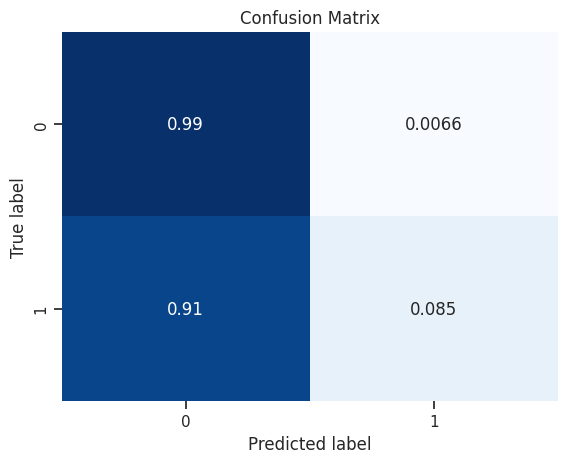

In [9]:
from autosklearn.metrics import balanced_accuracy, precision, recall, f1
report_dict = classification_report(y_test, y_pred, output_dict=True)
pr_auc = average_precision_score(y_test, automl.predict_proba(X_test)[:, 1])
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = report_dict["accuracy"]
recall = (
    report_dict["1.0"]["recall"] if "1.0" in report_dict else 0
)  # Recall for positive class
# F1-score for positive class
f1_score = report_dict["1.0"]["f1-score"] if "1.0" in report_dict else 0
# Calculate precision for positive class
positive_precision = precision_score(y_test, y_pred, pos_label=1)

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("F1-score: ", f1_score)
print("PR AUC Score: ", pr_auc)
print("Balanced Accuracy Score: ", balanced_accuracy)


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)

# Set the title and labels for the subplot
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")

## Converting and Saving Best Model to ONNX Format

In [ ]:
initial_types = [("input", FloatTensorType([None, X_train.shape[1]]))]
final_types = [
    ("label", Int64TensorType([None])),
    ("output", FloatTensorType([None, 2])),
]

In [ ]:
# Convert the best model to ONNX format with initial types
onnx_model = convert_sklearn(
    pipeline,
    "best_model",
    initial_types=initial_types,
    final_types=final_types,
    options={"zipmap": False},
)

# Infer shapes (optional but recommended)
onnx_model = shape_inference.infer_shapes(onnx_model)

# Define the path to save the ONNX model with timestamp
onnx_file_path = f"..\\models\\best_model.onnx"

# Save the ONNX model to a file
onnx.save_model(onnx_model, onnx_file_path)
joblib.dump(pipeline, "..\\models\\best_model_pipeline.pkl")

# Log the saved best model
logger.info(f"Best model saved successfully at '{onnx_file_path}'.")

## Testing onnx model

In [ ]:
target_test_value = 0
# X_test_single_row = np.array(df[df[target_column] == target_test_value].iloc[:, 1:].head(10).values)
X_test_single_row = np.array(
    df[df[target_column] == target_test_value].iloc[:, 1:].head(10).values
)
print(repr(X_test_single_row))
# Create an ONNX inference session with the loaded model
onnx_session = InferenceSession("..\\models\\best_model.onnx")
best_pipeline = joblib.load("..\\models\\best_model_pipeline.pkl")

print(onnx_session)
output_meta_names = [output.name for output in onnx_session.get_outputs()]
print("Output metadata names:", output_meta_names)

# Convert the input data to a dictionary with the appropriate key
# input_data = {'input': X_test_single_row.astype(np.float32)}
input_data = {"input": X_test_single_row.astype(np.float32)}

# Run inference with the ONNX model
output = onnx_session.run(None, input_data)
print(output)

# Assuming you have only one output, you can access it like this
output_data = output[0]
print(sum(output_data == target_test_value) / len(output_data))

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# X_train_summary = shap.kmeans(X_train, 10)
# print(X_train.values)

SHAP_X_train0 = best_pipeline.named_steps["scaler"].transform(X_train_resampled)
SHAP_X_train1 = best_pipeline.named_steps["poly_features"].transform(SHAP_X_train0)

SHAP_X_test0 = best_pipeline.named_steps["scaler"].transform(X_test)
SHAP_X_test1 = best_pipeline.named_steps["poly_features"].transform(SHAP_X_test0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
# Reduce the number to make the process faster
shape_instances = 1000  # N instances for use as the background distribution
SHAP_X_train = shap.utils.sample(SHAP_X_train1, shape_instances, random_state=42)
SHAP_X_test = shap.utils.sample(SHAP_X_test1, shape_instances, random_state=42)

explainer = shap.KernelExplainer(
    best_pipeline.named_steps["classifier"].predict_proba, SHAP_X_train
)
shap_values = explainer(SHAP_X_test)

In [ ]:
new_poly_features = best_pipeline.named_steps["poly_features"].get_feature_names_out(
    all_features
)

shap_values.feature_names = new_poly_features

# Take the 1's
small_shap_values = shap_values[:, : len(new_poly_features), 1]
expected_value = explainer.expected_value

vals = np.abs(small_shap_values.values).mean(0)
feature_names = new_poly_features

feature_importance = pd.DataFrame(
    list(zip(feature_names, vals)), columns=["col_name", "feature_importance_vals"]
)
feature_importance.sort_values(
    by=["feature_importance_vals"], ascending=False, inplace=True
)
top_important_feature = feature_importance.iloc[:20, 0].values

In [ ]:
%matplotlib inline

# print(shap_values[:, 0, 1])
# visualize the first prediction's explanation
# shap.plots.scatter(small_shap_values[:, "Income"], color=small_shap_values)
# shap.plots.bar(small_shap_values, max_display=20)
# shap.plots.heatmap(small_shap_values, instance_order=shap.Explanation.sum(1))
# shap.plots.force(
#     explainer.expected_value[1], small_shap_values.values, features=new_poly_features
# )

sex = [
    "Women" if small_shap_values[i, "Sex"].data == 0 else "Men"
    for i in range(small_shap_values.shape[0])
]
shap.plots.bar(small_shap_values.cohorts(sex).abs.mean(0))

shap.plots.violin(small_shap_values, feature_names=new_poly_features, max_display=20, plot_type="violin")

shap.plots.beeswarm(
    small_shap_values, max_display=20, order=shap.Explanation.abs.mean(0)
)

# Define the first slice object
lenght_features = 10
slice1 = slice(-1, -lenght_features-1, -1)

# Define the second slice object
slice2 = slice(-len(new_poly_features)+lenght_features, -len(new_poly_features)-1, -1)

# Combine the two plots
r1 = shap.plots.decision(
    explainer.expected_value[1],
    small_shap_values.values[:20],
    new_poly_features,
    feature_order="importance",
    # feature_display_range=slice(-1, -len(new_poly_features)-1, -1),
    feature_display_range=slice1,
    return_objects=True,
    ignore_warnings=True
)
shap.plots.decision(
    explainer.expected_value[1],
    small_shap_values.values[:20],
    new_poly_features,
    feature_order="importance",
    # feature_display_range=slice(-1, -len(new_poly_features)-1, -1),
    feature_display_range=slice2,
    xlim=r1.xlim,
    ignore_warnings=True
)

# shap.summary_plot(small_shap_values, SHAP_X_test, plot_size=(20,6))

Order for input:

1. HighBP
2. HighChol
3. CholCheck
4. BMI
5. Smoker
6. Stroke
7. Diabetes
8. PhysActivity
9. Fruits
10. Veggies
11. HvyAlcoholConsump
12. AnyHealthcare
13. NoDocbcCost
14. GenHlth
15. MentHlth
16. PhysHlth
17. DiffWalk
18. Sex
19. Age
20. Education
21. Income
